<a href="https://colab.research.google.com/github/aliflazuardi/Face-Mask-Detector/blob/main/Train_Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detector Jupyter Notebook for training Model

This notebook used to train the Machine Learning model for Face Mask Detector

**Import Depedencies** 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

**Import Dataset at GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Set Working Directory**

In [ ]:
DIRECTORY = os.getcwd()
PATH = 'gdrive/MyDrive/dataset'
DIRECTORY = os.path.join(DIRECTORY, PATH)
CATEGORIES = ["with_mask", "without_mask"]

**Load all dataset to list of data and labels**

In [ ]:
data = []
labels = []

for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


**One Hot Encoding for the labels**

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

**Initialize learning rate, epochs number, and batch size**

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

**Set up data for training preparation**

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

**Construct the training image generator for data augmentation**

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

**Load MobileNetV2 as Basemodel**

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


**Setup the Headmodel (Model on top of basemodel)**

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

**Place the headmodel on top of basemodel and freeze the layers basemodel**

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

**Compile the model**

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Train the model**

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 64s 339ms/step - loss: 0.4258 - accuracy: 0.8375 - val_loss: 0.1736 - val_accuracy: 0.9726
Epoch 2/20
95/95 [==============================] - 31s 328ms/step - loss: 0.1581 - accuracy: 0.9598 - val_loss: 0.0951 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 31s 322ms/step - loss: 0.1098 - accuracy: 0.9726 - val_loss: 0.0740 - val_accuracy: 0.9831
Epoch 4/20
95/95 [==============================] - 31s 327ms/step - loss: 0.0792 - accuracy: 0.9786 - val_loss: 0.0555 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 31s 325ms/step - loss: 0.0683 - accuracy: 0.9802 - val_loss: 0.0467 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 31s 327ms/step - loss: 0.0619 - accuracy: 0.9825 - val_loss: 0.0454 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 31s 325ms/step - loss: 0.0561 - accuracy: 0.9842 - val_loss: 0.0398 - val_accuracy: 0.9870

**Evaluating performance in the test dataset**

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



**Saving the model in h5 format**

In [ ]:
model.save("mask_detector.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**Plot the metrics**

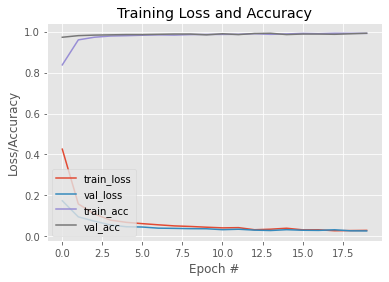

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig("plot.png")